<a href="https://colab.research.google.com/github/ta3h30nk1m/Neural_Style_Transfer_Practice/blob/main/Neural_Style_Transfer_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [113]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [137]:
from google.colab import drive
drive.mount('/content/gdrive')


#content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_path = '/content/gdrive/MyDrive/Neural_Style_Transfer/images/contents/cane.jpg/'
# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
#style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
style_path = '/content/gdrive/MyDrive/Neural_Style_Transfer/images/styles/brightNight.jpeg/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [115]:
def load_img(path_to_img):
  max_dim = 512  # 이미지 최대 크기
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape*scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  
  plt.imshow(image)
  if(title):
    plt.title(title)

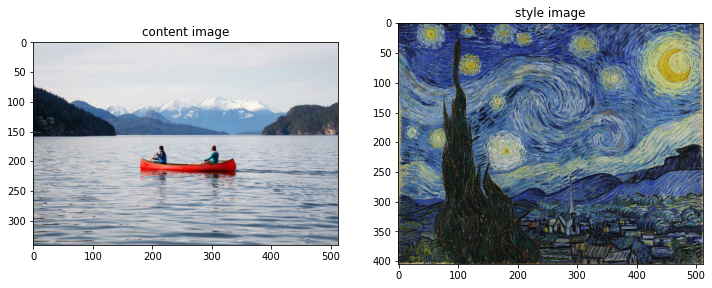

In [138]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1,2,1)
imshow(content_image, 'content image')

plt.subplot(1,2,2)
imshow(style_image, 'style image')

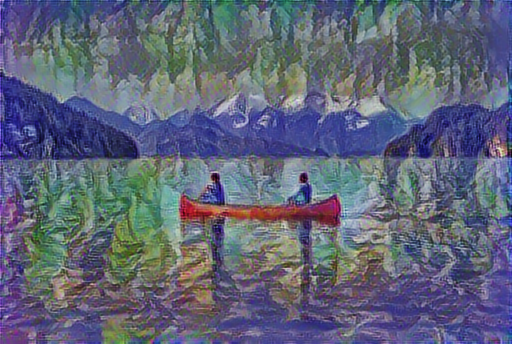

In [139]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

# Neural Style Transfer 종류

* pre-trained 모델을 기반으로 content 와 style 이미지를 입력으로 이용해 이미지 학습하는 방법

이미지 2장만으로 style transfer 가 가능하지만, 새로운 사진을 넣을 경우 다시 학습해야됨.
* pre-trained 모델을 기반으로 content 와 style 이미지를 입력으로 이용해 이미지 변환 네트워크를 학습하는 방법

이미지 2장으로 가능, 또 사진이 바뀌어도 변환 네트워크가 feed-forward만 하기 때문에 재학습 필요 없음.
* GAN 기반으로 style transfer 모델을 직접 학습

모델을 만들기만 하면 재학습이 필요없고 실시간 변환이 가능, but 학습을 위해 많은 데이터셋이 필요.

Paper: "A Neural Algorithm of Artistic Style"

pretrained 모델의 intermediate layer를 골라서 content and style images 의 feature vector 로 사용. 

In [141]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224,224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [142]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]


[('canoe', 0.6848016),
 ('paddle', 0.27549422),
 ('lakeside', 0.010714504),
 ('yawl', 0.0075320057),
 ('snorkel', 0.004173587)]

In [120]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_14
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [143]:
# Choose intermediate layers from the network to represent the style and cotent of the image:

content_layers = ['block5_conv2']

style_layers = [
                'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

In [144]:
# function to extract layers from the model
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [145]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("   shape: ", output.numpy().shape)
  print("   min: ", output.numpy().min())
  print("   max: ", output.numpy().max())
  print("   mean: ", output.numpy().mean())

block1_conv1
   shape:  (1, 405, 512, 64)
   min:  0.0
   max:  675.34076
   mean:  24.29381
block2_conv1
   shape:  (1, 202, 256, 128)
   min:  0.0
   max:  2914.6619
   mean:  150.67825
block3_conv1
   shape:  (1, 101, 128, 256)
   min:  0.0
   max:  7359.086
   mean:  144.11304
block4_conv1
   shape:  (1, 50, 64, 512)
   min:  0.0
   max:  16475.654
   mean:  568.4982
block5_conv1
   shape:  (1, 25, 32, 512)
   min:  0.0
   max:  4002.9038
   mean:  48.654373


the content of an image is represented by the values of the intermediate feature maps

the style of an image can be described by the means and correlations across the different feature maps. --> this can be done by calculating a Gram matrix

In [146]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)  # https://www.tensorflow.org/api_docs/python/tf/einsum
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result / (num_locations)

In [147]:
# A model that returns the style and content tensors
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
  
  def call(self, inputs):
    # Expects float input in [0, 1]
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [148]:
# when called on an image, this model returns the gram matrix of the style_layers and content of the content_layers
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("   ", name)
  print("     shape:", output.numpy().shape )
  print("     min:", output.numpy().min() )
  print("     max:", output.numpy().max() )
  print("     mean:", output.numpy().mean() )
  print()

print('Contents:')
for name, output in sorted(results['content'].items()):
  print("   ", name)
  print("     shape:", output.numpy().shape )
  print("     min:", output.numpy().min() )
  print("     max:", output.numpy().max() )
  print("     mean:", output.numpy().mean() )


Styles:
    block1_conv1
     shape: (1, 64, 64)
     min: 0.0003248161
     max: 67738.02
     mean: 525.88367

    block2_conv1
     shape: (1, 128, 128)
     min: 0.0
     max: 136497.17
     mean: 14469.264

    block3_conv1
     shape: (1, 256, 256)
     min: 0.0
     max: 629479.1
     mean: 14431.109

    block4_conv1
     shape: (1, 512, 512)
     min: 0.0
     max: 5044407.0
     mean: 167450.45

    block5_conv1
     shape: (1, 512, 512)
     min: 0.0
     max: 200432.53
     mean: 1311.12

Contents:
    block5_conv2
     shape: (1, 21, 32, 512)
     min: 0.0
     max: 1715.0112
     mean: 12.455996


With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

In [149]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

def normalize(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# optmizers: the paper recommends LBFGs, but this example uses Adam
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) # beta_1: exponential decay rate of lr, epsilon: a small constant for numerical stability?

In [150]:
style_weight = 1e-2
content_weight = 1e4

def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)for name in style_outputs.keys()] )
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)for name in content_outputs.keys()] )
  content_loss *= content_weight / num_content_layers

  loss = style_loss + content_loss
  return loss

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(normalize(image))


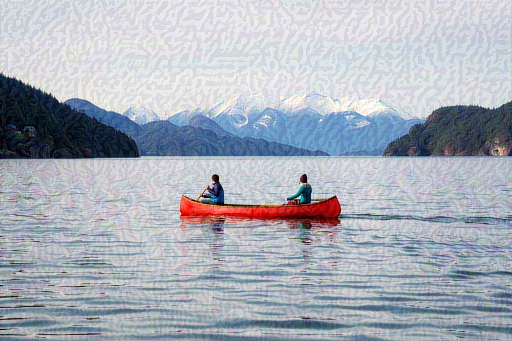

In [151]:
image = tf.Variable(content_image)

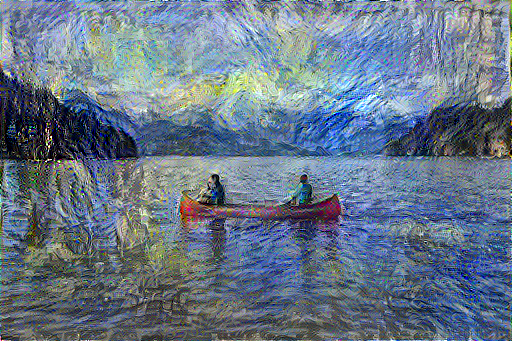

In [153]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
tensor_to_image(image)

The downside of this basic implementation is that it produces a lot of high frequency artifacts. 
Decrease these using an explicit regularization term on the high frequency components of the image --> term: total variation loss

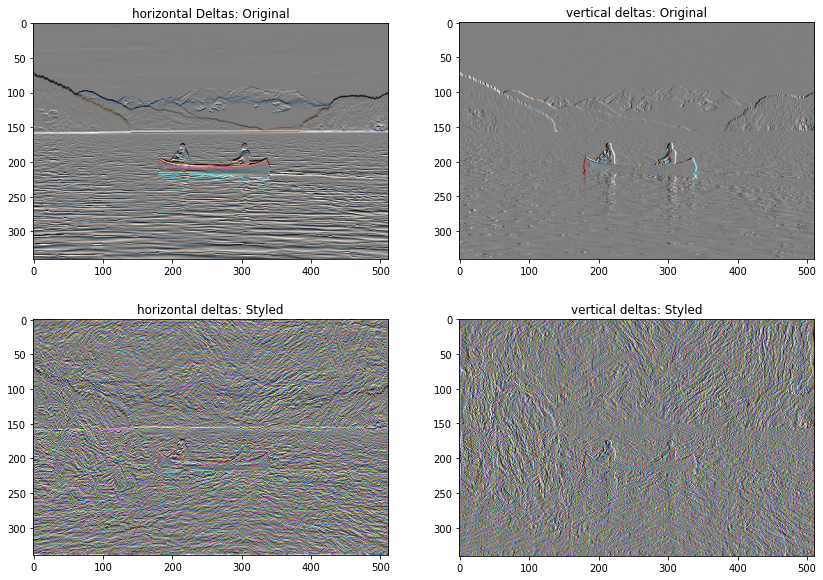

In [154]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
  return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2,2,1)
imshow(normalize(2*y_deltas+0.5), "horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(normalize(2*x_deltas+0.5), "vertical deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(normalize(2*y_deltas+0.5), "horizontal deltas: Styled")

plt.subplot(2,2,4)
imshow(normalize(2*x_deltas+0.5), "vertical deltas: Styled")

this high frequency component is basically an edge-detector. 

The regularization loss associated with this is the sum of the squares of the values:

In [155]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_loss(image).numpy()

# tensorflow already have this function
tf.image.total_variation(image).numpy()

array([113332.484], dtype=float32)

Optimization (with regularization)

In [165]:
total_variation_weight = 30

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight * tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(normalize(image))

image = tf.Variable(content_image)

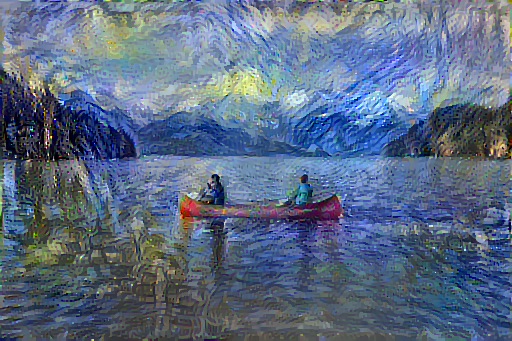

In [166]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
tensor_to_image(image)

In [ ]:
# saving the image

file_name = 'stylized_image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(file_name)